### 0-Importamos las librerias necesarias

In [1]:

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.naive_bayes import GaussianNB
import os
import scipy.io
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


###  1-Importación de datos de ondas cerebrales (electroencefalograma)


Primero cargaremos los datos de el grupo control

In [2]:

# Definimos los canales del EEG que formaran parte de nuestras columnas
chanels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']


# Rutas base para cada conjunto de datos
control_path1 = '/Users/Ale/Downloads/adhd1/Control_part1/Control_part1/'
control_path2 = '/Users/Ale/Downloads/adhd1/Control_part2/Control_part2/'

# Obtenemos los nombres de todos los archivos en ambos directorios
control_files1 = [os.path.join(control_path1, f) for f in os.listdir(control_path1) if os.path.isfile(os.path.join(control_path1, f))]
control_files2 = [os.path.join(control_path2, f) for f in os.listdir(control_path2) if os.path.isfile(os.path.join(control_path2, f))]

# Combinamos las listas de archivos
control_files = control_files1 + control_files2

control_data = []

# Iteramos sobre cada archivo
for i, file_path in enumerate(control_files):
    mat_data = scipy.io.loadmat(file_path)
    name = os.path.basename(file_path).split('.')[0]
    values = mat_data[name]

    # Creamos un DataFrame para cada archivo .mat
    df = pd.DataFrame(values, columns=chanels)

    # Insertamos las columnas adicionales
    df.insert(0, 'patient_ID', f'control-{i}',)
    df.insert(1, 'type', 0)

    # Agregamos el DataFrame a la lista
    control_data.append(df)

# Concatenamos todos los DataFrames en uno solo
control = pd.concat(control_data, ignore_index=True)


Continuamos cargando los datos de el grupo ADHD

In [3]:

# Rutas base para cada conjunto de datos
ADHD_path1 = '/Users/Ale/Downloads/adhd1/ADHD_part1/ADHD_part1/'
ADHD_path2 = '/Users/Ale/Downloads/adhd1/ADHD_part2/ADHD_part2/'

# Obtenemos los nombres de todos los archivos en ambos directorios
ADHD_files1 = [os.path.join(ADHD_path1, f) for f in os.listdir(ADHD_path1) if os.path.isfile(os.path.join(ADHD_path1, f))]
ADHD_files2 = [os.path.join(ADHD_path2, f) for f in os.listdir(ADHD_path2) if os.path.isfile(os.path.join(ADHD_path2, f))]

# Combinamos las listas de archivos
ADHD_files = ADHD_files1 + ADHD_files2

adhd_data = []

# Iteramos sobre cada archivo
for i, file_path in enumerate(ADHD_files):
    mat_data = scipy.io.loadmat(file_path)
    name = os.path.basename(file_path).split('.')[0]
    values = mat_data[name]

    # Creamos un DataFrame para cada archivo .mat
    df = pd.DataFrame(values, columns=chanels)

    # Insertamos las columnas adicionales
    df.insert(0, 'patient_ID', f'ADHD-{i}',)
    df.insert(1, 'type', 1)

    # Agregamos el DataFrame a la lista
    adhd_data.append(df)

# Concatenamos todos los DataFrames en uno solo
adhd = pd.concat(adhd_data, ignore_index=True)


Creamos un nuevo df concatenando los anteriores y guardamos el numero de participantes

In [4]:

#Concatenamos Nuestros df
df = pd.concat([adhd, control], ignore_index=True)

#Contamos cuantos pacientes tenemos lo que será útil más tarde
n_patients = len(df['patient_ID'].unique())

df.head()


,patient_ID,type,Fp1,Fp2,F3,F4,C3,C4,P3,P4,...,O2,F7,F8,T7,T8,P7,P8,Fz,Cz,Pz
0,ADHD-0,1,261.0,402.0,16.0,261.0,126.0,384.0,126.0,236.0,...,236.0,200.0,16.0,200.0,494.0,126.0,236.0,121.0,367.0,121.0
1,ADHD-0,1,121.0,191.0,-94.0,85.0,16.0,200.0,126.0,52.0,...,273.0,16.0,-57.0,126.0,347.0,52.0,52.0,15.0,121.0,-19.0
2,ADHD-0,1,-55.0,85.0,-204.0,15.0,-57.0,200.0,52.0,126.0,...,200.0,-20.0,-94.0,126.0,420.0,52.0,126.0,-55.0,261.0,85.0
3,ADHD-0,1,191.0,85.0,52.0,50.0,89.0,236.0,163.0,89.0,...,89.0,89.0,-57.0,236.0,420.0,126.0,126.0,15.0,85.0,-55.0
4,ADHD-0,1,-55.0,-125.0,-204.0,-160.0,-204.0,16.0,-241.0,-241.0,...,16.0,-20.0,-131.0,89.0,310.0,-57.0,52.0,-55.0,15.0,-336.0


### 2- Creamos nuestras variables de entrenamiento y pruebas

In [198]:

# Tamaño variable de grupo de test por defecto 25%
test_size = 0.25

#Pasamos el test size a un valor sobre el que hacer los saltos de las iteraciones
iteration_jumps = 100 // (test_size * 100)

#Creamos una variable train que coja los pacientes del rango 0-120 exceptuando los divisores de 'iteration_jumps'
#estas excepciones se usaran para en conjunto test
test = df[df['patient_ID'].str.split('-').str[1].astype(int).isin(range(0, n_patients, int(iteration_jumps) ))]
train = df[~df['patient_ID'].str.split('-').str[1].astype(int).isin(range(0, n_patients, int(iteration_jumps) ))]


In [199]:

#diferenciamos la X de la y para entrenar al modelo
y_train, y_test = train['type'], test['type']
X_train, X_test = train.drop(columns=['type']), test.drop(columns=['type'])

#Selecionamos unicamente las columnas con valores enteros y las pasamos a numpy array
X_train_values = X_train.iloc[:,1:].values
X_test_values = X_test.iloc[:,1:].values

#Normalizamos los valores para aumentar la precisón de las prediciones
scaler = StandardScaler()
X_train_values = scaler.fit_transform(X_train_values)
X_test_values = scaler.transform(X_test_values)


### 3- Creamos nuestra red neuronal

In [200]:

#Número de caracteristicas y paso de tiempo
n_features = len(chanels)  
n_timesteps = X_train_values.shape[1] // n_features

# Remodelar los datos para la NN
X_train_nn = X_train_values.reshape((-1, n_timesteps, n_features))
X_test_nn = X_test_values.reshape((-1, n_timesteps, n_features))

# Construir el modelo RNN
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(512, activation='tanh', input_shape=(n_timesteps, n_features)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_nn, y_train, epochs=2, batch_size=512, validation_data=(X_test_nn, y_test))

# Realizar predicciones
y_pred = model.predict(X_test_nn)
y_pred = y_pred.flatten()


Epoch 1/2
3175/3175 [==============================] - 94s 29ms/step - loss: 0.4472 - accuracy: 0.7898 - val_loss: 0.6446 - val_accuracy: 0.6895
Epoch 2/2
16905/16905 [==============================] - 50s 3ms/step


### 4-Analisis de resultados

In [205]:

#Añadimos Nuestras prediciones y valores reales nuestro df X_test para hacer comparaciones
X_test['pred'] = y_pred
X_test['real'] = y_test

#Creamos un nuevo df para almacenar el resultado de nuuestras predicciones para poder operar de forma práctica con el
result = pd.DataFrame(columns=['patient_ID', 'real_count', 'pred_count', 'real'])
X_test = X_test.sort_values(by='patient_ID')

#iteramos sobre nuestros usuarios de test
for i in X_test['patient_ID'].unique():
    #selecionamos las filas asociadas a cada paciente
    person = X_test[X_test['patient_ID'] == i]
    #añadimos una columna de id, suma de la regresion logistica de esa persona, suma de valores reales y el valor binario real
    new_row = [i, len(person), person['pred'].sum(), person['real'].max()]
    new_col = pd.DataFrame([new_row], columns=result.columns)
    result = pd.concat([result, new_col], ignore_index=True)



### 5-calcular umbral de regressión óptimo

In [206]:

#Creamos las variables de mejor precisión y el mejor valor de umbral
best_thershold = 0
best_accuracy = 0

#iteramos los valores óptimos de umbral
for i in range(100,300):
    #probamos el umbral del 1.00 al 3.00 iterando por 0.01
    result['pred'] = (result['pred_count'] > result['real_count'] / (i/100) ).astype(int)
    result['real'] = result['real'].astype(int)
    
    #calculamos la precision del umbral a iterar
    accuracy = accuracy_score(result['real'], result['pred'])
    
    #actualizamos el umbral si la precisión es mayor
    if accuracy > best_accuracy:
        best_thershold = i/100
        best_accuracy = accuracy
        
print('maxima precision del modelo teoricamente es:', best_accuracy,'%')
print('mejor valor de umbral de regresion:', best_thershold)


maxima precision del modelo teoricamente es: 0.967741935483871 %
mejor valor de umbral de regresion: 1.6


### 6-Calculo final de la precisión aproximada del modelo

In [207]:

#Agregamos al df del resultado el mejor umbral de la regresión
result['pred'] = (result['pred_count'] > result['real_count'] / best_thershold ).astype(int)
result['real'] = result['real'].astype(int)

#imprimimos el reporte de precisión del modelo mas optimo
report = classification_report(result['real'], result['pred'])
print(report)


              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.94      0.97        16

    accuracy                           0.97        31
   macro avg       0.97      0.97      0.97        31
weighted avg       0.97      0.97      0.97        31



### 7- Representación gráfica de los resultados

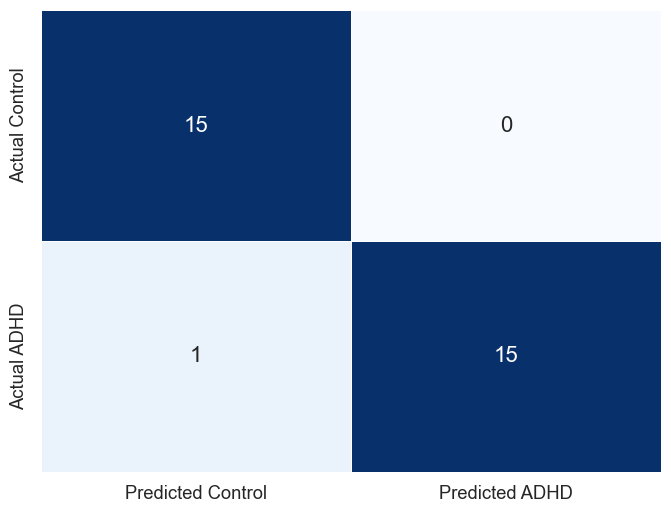

In [208]:

#creamos nuestra variables de mariz de confusión
confusion = confusion_matrix(result['real'], result['pred'])

# Puedes convertir la matriz de confusión a un DataFrame para una mejor visualización
confusion_df = pd.DataFrame(confusion, columns=['Predicted Control', 'Predicted ADHD'], index=['Actual Control', 'Actual ADHD'])

# Utiliza Seaborn para crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=0.5, annot_kws={"size": 16})
plt.show()


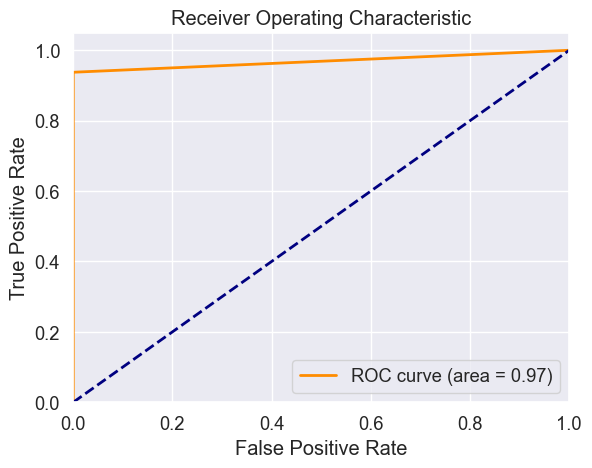

In [210]:

from sklearn.metrics import roc_curve, auc

# Calcular las tasas de verdaderos y falsos positivos y el umbral
fpr, tpr, thresholds = roc_curve(result['real'], result['pred'])

# Calcular el área bajo la curva ROC
roc_auc = auc(fpr, tpr)

# Crear la gráfica
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
